In [10]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec

In [11]:
label_index=302

In [12]:
feature = pd.read_pickle('../corpus/corax_features.pkl')
label = pd.read_pickle('../corpus/corax_labels.pkl')
adj_matrix=pd.read_pickle('../corpus/corax_adj.pkl')

label_onehot = torch.tensor(label)
y = torch.topk(label_onehot, 1)[1].squeeze(1).numpy()

G = nx.from_numpy_matrix(adj_matrix)

In [13]:
# allLabel.values

In [14]:
from torch_geometric.data import Data

# 确定x
x = torch.tensor(feature, dtype=torch.float)

# 确定edge_index
edge_index = torch.tensor(list(G.edges)).t().contiguous()

# 确定y
y = torch.tensor(y, dtype=torch.long)

train_mask = np.zeros(x.shape[0], dtype=bool)
val_mask = np.zeros(x.shape[0], dtype=bool)
test_mask = np.zeros(x.shape[0], dtype=bool)

train_mask[0:1180]=True
val_mask[1180:1680]=True
test_mask[1680:2681]=True

data=Data(x=x,edge_index=edge_index,y=y,train_mask=train_mask,val_mask=val_mask,test_mask=test_mask)
data

Data(x=[2680, 302], edge_index=[2, 5148], y=[2680], train_mask=[2680], val_mask=[2680], test_mask=[2680])

In [15]:
# node2vec模型  最好0.63左右
model = Node2Vec(edge_index=data.edge_index,
                 embedding_dim=128, # 节点维度嵌入长度
                 walk_length=5, # 序列游走长度
                 context_size=4, # 上下文大小
                 walks_per_node=1, # 每个节点游走1个序列
                 p=1,
                 q=1,
                 sparse=True # 权重设置为稀疏矩阵
                )

# 迭代器
loader = model.loader(batch_size=128, shuffle=True)
# 优化器
optimizer = torch.optim.SparseAdam(model.parameters(), lr=0.01)

# 3.开始训练
model.train()

for epoch in range(1000):
    total_loss = 0 # 每个epoch的总损失
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw, neg_rw) # 计算损失
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # 使用逻辑回归任务进行测试生成的embedding效果
    with torch.no_grad():
        model.eval() # 开启测试模式
        z = model() # 获取权重系数，也就是embedding向量表
        
        # z[data.train_mask] 获取训练集节点的embedding向量
        acc = model.test(z[data.train_mask], data.y[data.train_mask],
                         z[data.test_mask], data.y[data.test_mask],
                         max_iter=150) # 内部使用LogisticRegression进行分类测试
    
    # 打印指标
    print(f'Epoch: {epoch:02d}, Loss: {total_loss:.4f}, Acc: {acc:.4f}')


Epoch: 00, Loss: 158.4787, Acc: 0.1990
Epoch: 01, Loss: 150.1582, Acc: 0.1970
Epoch: 02, Loss: 142.3399, Acc: 0.2000
Epoch: 03, Loss: 127.0016, Acc: 0.1980
Epoch: 04, Loss: 127.5067, Acc: 0.1990
Epoch: 05, Loss: 122.3947, Acc: 0.1980
Epoch: 06, Loss: 119.3906, Acc: 0.1980
Epoch: 07, Loss: 116.6294, Acc: 0.2030
Epoch: 08, Loss: 115.5893, Acc: 0.2040
Epoch: 09, Loss: 111.8848, Acc: 0.2020
Epoch: 10, Loss: 108.9959, Acc: 0.2090
Epoch: 11, Loss: 109.1435, Acc: 0.2110
Epoch: 12, Loss: 106.8535, Acc: 0.2110
Epoch: 13, Loss: 105.9115, Acc: 0.2140
Epoch: 14, Loss: 103.3560, Acc: 0.2200
Epoch: 15, Loss: 100.6507, Acc: 0.2200
Epoch: 16, Loss: 101.5682, Acc: 0.2220
Epoch: 17, Loss: 98.8984, Acc: 0.2210
Epoch: 18, Loss: 98.3121, Acc: 0.2230
Epoch: 19, Loss: 96.3015, Acc: 0.2250
Epoch: 20, Loss: 95.1707, Acc: 0.2320
Epoch: 21, Loss: 93.1796, Acc: 0.2300
Epoch: 22, Loss: 92.2204, Acc: 0.2340
Epoch: 23, Loss: 91.4254, Acc: 0.2410
Epoch: 24, Loss: 91.1670, Acc: 0.2420
Epoch: 25, Loss: 89.5848, Acc: 0.

d:\softwares\Python\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
d:\softwares\Python\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


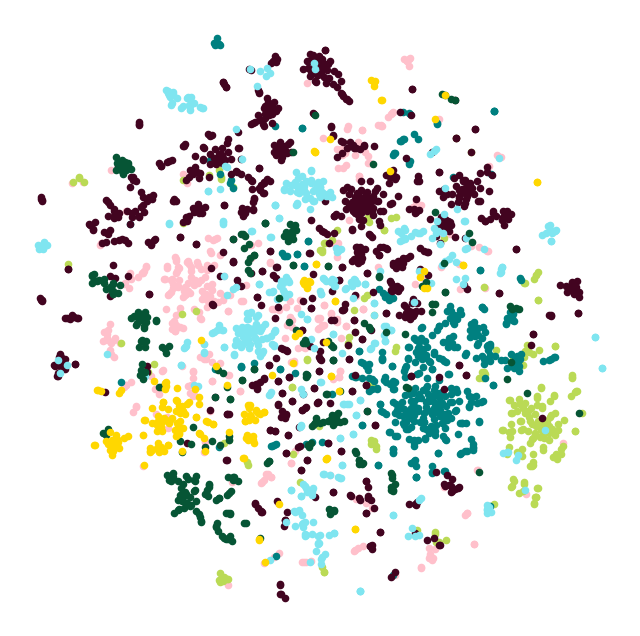

In [16]:

# 可视化节点的embedding
with torch.no_grad():
    # 不同类别节点对应的颜色信息
    colors = [
            '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
            '#ffd700'
        ]

    model.eval() # 开启测试模式
    # 获取节点的embedding向量，形状为[num_nodes, embedding_dim]
    z = model(torch.arange(data.num_nodes))
    # 使用TSNE先进行数据降维，形状为[num_nodes, 2]
    z = TSNE(n_components=2).fit_transform(z.detach().numpy())
    y = data.y.detach().numpy()

    plt.figure(figsize=(8, 8))
    
    # 绘制不同类别的节点
    for i in range(7):
        # z[y==0, 0] 和 z[y==0, 1] 分别代表第一个类的节点的x轴和y轴的坐标
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()